#### Imports etc

In [2]:
nb_samples = 64
# list_features = ["longitude", "latitude", "groundspeed"] #, "track"] #, "altitude"]
# list_features = ["longitude", "latitude", "track"] #, "track"] #, "altitude"]
list_features = ["longitude", "latitude"]  # , "track"] #, "altitude"]
input_dim = len(list_features)

In [3]:
%load_ext autoreload
%autoreload 2

In [58]:
from traffic.core import Flight, Traffic

from trajectory_clustering.feature_preparation import fit_scaler, prepare_features, traffic_from_features

import wandb
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import numpy as np
import numpy.typing as npt
import pandas as pd
pd.set_option("display.max_columns", None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm.autonotebook import tqdm


np.random.seed(0)

torch.manual_seed(0)

t = Traffic.from_file("./data/resampled_t_near_ap.parquet")


#### Get features

In [5]:
t_f = t.query("runway_name == '28'")
t_f

,count
flight_id,
AAL93_7720,64
SWR25P_4024,64
SWR252H_6245,64
SWR252H_6246,64
SWR2530_3232,64
SWR253J_1323,64
SWR253J_1371,64
SWR253J_1539,64
SWR253J_1743,64


In [8]:
scaler = fit_scaler(t_f.data[list_features].to_numpy())
X, flight_order = prepare_features(t_f, list_features, scaler)
X = X.reshape(-1, 64, 2).swapaxes(1, 2)


In [9]:
X.shape

(2617, 2, 64)

(-1.0, 1.0)

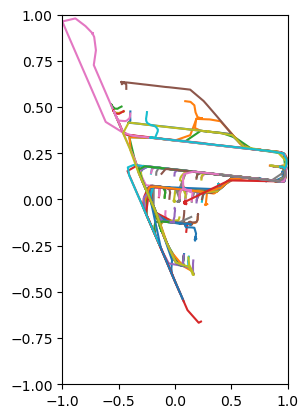

In [57]:
# check that teh reshaped X is correct
ax = plt.subplot(1, 2, 1)
for _ in range(100):
    idx = np.random.randint(0, X.shape[0])
    ax.plot(X[idx, 0, :], X[idx, 1, :])
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)


In [61]:
np.linspace(0, 1, 11)[:-1]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [218]:
def get_flight_image(flight_X: npt.NDArray, interpolation_precision=512, image_height: int = 64) -> npt.NDArray:
    image = np.zeros((image_height, image_height))

    interpolation_points = np.linspace(0, image_height, interpolation_precision + 1)[:-1]

    n_points = flight_X.shape[-1]

    interp_x = np.interp(interpolation_points, np.linspace(0, image_height, n_points + 1)[:-1], flight_X[0])
    interp_y = np.interp(interpolation_points, np.linspace(0, image_height, n_points + 1)[:-1], flight_X[1])

    # print(np.max(interp_x), np.max(interp_y))

    for i in range(interpolation_precision):
        x_pixel = int(interp_x[i])
        y_pixel = int(interp_y[i])

        if image[y_pixel, x_pixel] == 0:
            image[y_pixel, x_pixel] = 5
        elif image[y_pixel, x_pixel] < 10:
            image[y_pixel, x_pixel] += 1


    return image

In [219]:
list_features

['longitude', 'latitude']

In [220]:
from scipy.ndimage import gaussian_filter

In [221]:
def get_images(
    X: npt.NDArray,
    interpolation_precision=512,
    image_height: int = 64,
    gaussian_filter_sigma: float = 0.,
) -> list[npt.NDArray]:
    """
    Get list of matrix images from X. To be used with matplotlib.pyplot.imshow() with origin='lower' (lower left)
    """
    images = []

    X = (X + 1) * ((image_height - 1) / image_height) * image_height / 2

    for i in range(X.shape[0]):
        images.append(
            get_flight_image(X[i], interpolation_precision=interpolation_precision, image_height=image_height)
        )

    if gaussian_filter_sigma > 0:
        images = gaussian_filter(images, sigma=gaussian_filter_sigma, axes=[1, 2])

    return images # type: ignore

In [392]:
# images = get_images(X, interpolation_precision=2048, image_height=128, gaussian_filter_sigma=0.5)
images = get_images(X, interpolation_precision=2048, image_height=64, gaussian_filter_sigma=0.5)

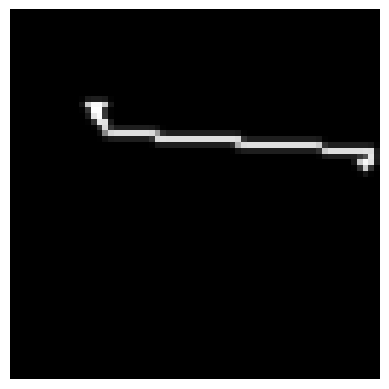

In [408]:
idx = np.random.randint(0, X.shape[0])

# Plot the original trajectory
# # flight = t_f[flight_order[idx]]
# plt.plot(X[idx, 0, :], X[idx, 1, :], 'k')
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
# plt.axis('off')
# plt.show()

# Plot the image
image = images[idx]

plt.imshow(image, cmap='gray', origin="lower")
plt.axis('off')
plt.show()

#### Transform the features in an image

In [409]:
images[0].shape

(64, 64)

In [429]:
X_images = np.array(images).reshape(-1, 1, images[0].shape[0], images[0].shape[1])
X_images = X_images / 10
X_images.shape

# X_images.reshape(-1, 128, 128, 1).shape

(2617, 1, 64, 64)

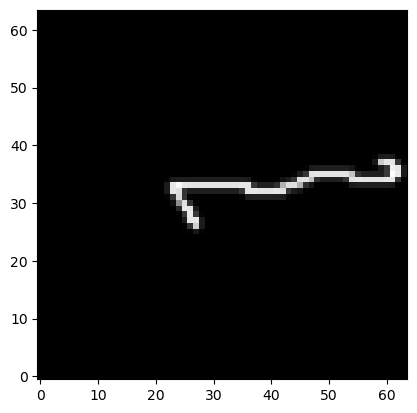

In [433]:
X_images[0, 0, :, :].shape

plt.imshow(X_images[idx, 0, :, :], cmap='gray', origin="lower")


In [1223]:
class Convolutional2d_AE(nn.Module):
    def __init__(self, channels: int = 1, relu: nn.Module = nn.ReLU(), latent_dim: int = 2, image_size: int = 64):
        super(Convolutional2d_AE, self).__init__()

        self.relu = relu
        self.kernel_size = 3
        self.normal_dist = torch.distributions.Normal(0, 1)

        self.encoder = nn.Sequential(
            # input: 1, image_size, image_size
            nn.Conv2d(channels, 16, kernel_size=self.kernel_size, stride=2, padding=1),
            # 16, image_size/2, image_size/2
            # nn.BatchNorm2d(16),
            self.relu,
            nn.Conv2d(16, 32, kernel_size=self.kernel_size, stride=2, padding=1),
            # 32, image_size/4, image_size/4
            # nn.BatchNorm2d(32),
            self.relu,
            nn.Conv2d(32, 64, kernel_size=self.kernel_size, stride=2, padding=1),
            # 64, image_size/8, image_size/8
            # nn.BatchNorm2d(64),
            self.relu,
        )

        # self.encoder_linear = nn.Linear(64 * (image_size // 8) * (image_size // 8), latent_dim)
        # self.encoder_sigma = nn.Linear(64 * (image_size // 8) * (image_size // 8), latent_dim)
        self.linear_step = nn.Sequential(
            nn.Linear(64 * (image_size // 8) * (image_size // 8), 32 * (image_size // 8) * (image_size // 8)),
            self.relu,
            nn.Linear(32 * (image_size // 8) * (image_size // 8), 16 * (image_size // 8) * (image_size // 8)),
            self.relu,
            nn.Linear(16 * (image_size // 8) * (image_size // 8), 8),
            self.relu,
        )

        self.encoder_linear = nn.Linear(8, latent_dim)
        self.encoder_sigma = nn.Sequential(
            nn.Linear(8, latent_dim),
            # nn.Softplus(),/
            nn.LeakyReLU(),
        )

        # self.decoder_linear = nn.Linear(latent_dim, 64 * (image_size // 8) * (image_size // 8))
        self.decoder_linear = nn.Sequential(
            nn.Linear(latent_dim, 8),
            self.relu,
            nn.Linear(8, 16 * (image_size // 8) * (image_size // 8)),
            self.relu,
            nn.Linear(16 * (image_size // 8) * (image_size // 8), 32 * (image_size // 8) * (image_size // 8)),
            self.relu,
            nn.Linear(32 * (image_size // 8) * (image_size // 8), 64 * (image_size // 8) * (image_size // 8)),
            self.relu,
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=self.kernel_size, stride=2, padding=1, output_padding=1),
            # 32, image_size/4, image_size/4
            # nn.BatchNorm2d(32),
            self.relu,
            nn.ConvTranspose2d(32, 16, kernel_size=self.kernel_size, stride=2, padding=1, output_padding=1),
            # 16, image_size/2, image_size/2
            # nn.BatchNorm2d(16),
            self.relu,
            nn.ConvTranspose2d(16, channels, kernel_size=self.kernel_size, stride=2, padding=1, output_padding=1),
            # channels, image_size, image_size
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        encoded_shape = x.shape
        # x = x.view(x.size(0), -1)
        # mu = self.encoder_linear(x)
        # # mu = nn.Tanh()(mu)
        # sigma = torch.exp(self.encoder_sigma(x))
        # # x = nn.Tanh()(mu)
        # # x = mu.clone()
        # # x = 6 * x
        # # x = mu

        x= self.linear_step(x.view(x.size(0), -1))
        # encoded_shape = x.shape
        mu = self.encoder_linear(x)
        sigma = torch.exp(self.encoder_sigma(x))

        # self.latent = x.clone()
        self.latent = mu.clone()

        x = mu + sigma * self.normal_dist.sample(mu.shape).to(x.device)
        self.noisy_latent = x.clone()

        self.kl = (mu**2 + sigma**2 - torch.log(sigma) - 0.5).sum() / x.shape[0]

        x = self.decoder_linear(x)
        x = x.view(x.size(0), 64, encoded_shape[2], encoded_shape[3])
        x = self.decoder(x)
        return x

In [1196]:
cae = Convolutional2d_AE()

In [1197]:
Y_images = cae(torch.tensor(X_images, dtype=torch.float32)).detach().numpy()

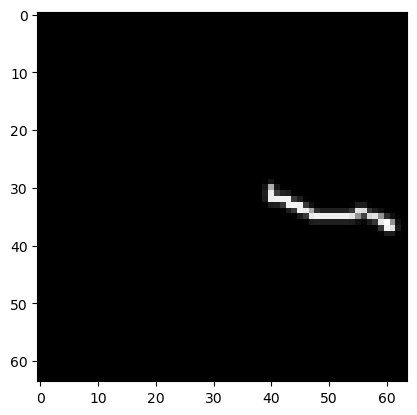

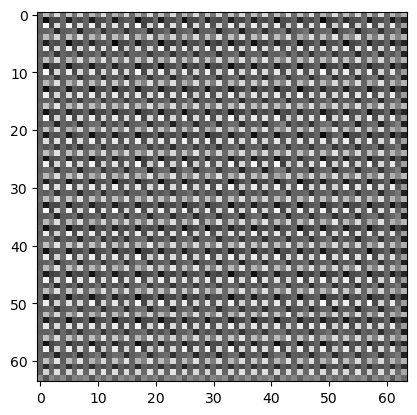

In [1198]:
idx = np.random.randint(0, len(X_images))

plt.imshow(X_images[idx].reshape(64, 64), cmap='gray')
plt.show()

plt.imshow(Y_images[idx].reshape(64, 64), cmap='gray')
plt.show()


In [1224]:
def train(
    model: Convolutional2d_AE,
    train_loader: DataLoader,
    validation_loader: DataLoader,
    epochs: int,
    lr: float,
    device: str = "cpu",
    kl_weight: float = 0.05,
):
    model = model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    # criterion = nn.MSELoss()
    criterion = nn.BCELoss(reduction="mean")

    epoch_losses = []
    epoch_val_losses = []
    epoch_bce_losses = []
    epoch_kl_losses = []

    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        running_bce_loss = 0.0
        running_kl_loss = 0.0

        # use_kl = np.random.rand() < 0.2 and epoch > 5 and epochs - epoch > 5
        # if use_kl:
        #     print("kl used")
        use_kl = epoch % 7 == 0 and epoch > 5 and epochs - epoch > 5 and epoch_kl_losses[-1] > 5
        if use_kl:
            print("kl used")
        for data in train_loader:
            # print(data[0].shape)
            # img, _ = data[0]
            img = data[0]
            img = img.to(device)
            optimizer.zero_grad()

            output = model(img)
            loss_bce = criterion(output, img)
            loss_kl = model.kl

            if use_kl:
                # loss = loss_bce/kl_weight + loss_kl * kl_weight / 100
                # loss = loss_bce + loss_kl * kl_weight
                loss = loss_bce + loss_kl / 1000
            else:
                loss = loss_bce

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_bce_loss += loss_bce.item()
            running_kl_loss += loss_kl.item()

        print(
            f"epoch: {epoch + 1}, loss: {running_loss / len(train_loader)}, bce: {running_bce_loss / len(train_loader)}, kl: {running_kl_loss / len(train_loader)}"
        )
        epoch_losses.append(running_loss / len(train_loader))
        epoch_bce_losses.append(running_bce_loss / len(train_loader))
        epoch_kl_losses.append(running_kl_loss / len(train_loader))

        running_loss = 0.0
        for data in validation_loader:
            # img, _ = data[0]
            img = data[0]
            img = img.to(device)
            output = model(img)
            loss = criterion(output, img)
            running_loss += loss.item()

        print(f"validation loss: {running_loss / len(validation_loader)}")
        epoch_val_losses.append(running_loss / len(validation_loader))

    return model, epoch_losses, epoch_val_losses, epoch_bce_losses

In [1225]:
dataset = TensorDataset(torch.tensor(X_images, dtype=torch.float32))

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])


In [1226]:
# batch_size = 64
batch_size = 64
# epochs = 25
epochs = 50

workers= 0
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
)

device = "mps"

model = Convolutional2d_AE(relu=nn.LeakyReLU())
# model = Convolutional2d_AE(relu=nn.ReLU())

model, epoch_loss, valid_loss, epoch_bce_loss = train(
    epochs=epochs,
    model=model,
    train_loader=train_loader,
    validation_loader=test_loader,
    device=device,
    # lr=1e-3,
    lr=1e-3,
    # kl_weight=0.01
)


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 1, loss: 0.17749589828379225, bce: 0.17749589828379225, kl: 10.390380711266488
validation loss: 0.045576803386211395
epoch: 2, loss: 0.041219586337154564, bce: 0.041219586337154564, kl: 2.8652924732728438
validation loss: 0.03769381427102619
epoch: 3, loss: 0.03710254642999533, bce: 0.03710254642999533, kl: 3.9299312793847285
validation loss: 0.035445120806495346
epoch: 4, loss: 0.036160890803192604, bce: 0.036160890803192604, kl: 6.291082873488918
validation loss: 0.03570062377386623
epoch: 5, loss: 0.035840979918385994, bce: 0.035840979918385994, kl: 3.5117651043516216
validation loss: 0.035779524594545364
epoch: 6, loss: 0.03569613216501294, bce: 0.03569613216501294, kl: 4.231140165617972
validation loss: 0.035733270562357373
epoch: 7, loss: 0.03468150177010984, bce: 0.03468150177010984, kl: 60.376477747252494
validation loss: 0.0329525712877512
kl used
epoch: 8, loss: 0.04742482722257123, bce: 0.03643898891680168, kl: 10.985838584827654
validation loss: 0.03535334641734759
e

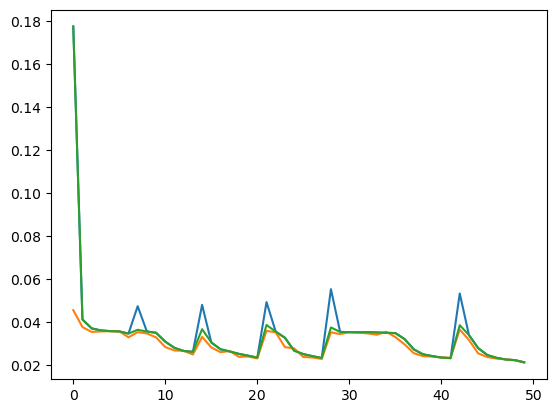

In [1227]:
plt.plot(epoch_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.plot(epoch_bce_loss, label='train_bce')

In [1260]:
model

Convolutional2d_AE(
  (relu): LeakyReLU(negative_slope=0.01)
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
  )
  (linear_step): Sequential(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=1024, out_features=8, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (encoder_linear): Linear(in_features=8, out_features=2, bias=True)
  (encoder_sigma): Sequential(
    (0): Linear(in_features=8, out_features=2, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (decoder_linear): Se

In [1228]:
model.eval()
model.to("cpu")
Y_images = model(torch.tensor(X_images, dtype=torch.float32)).detach().numpy()

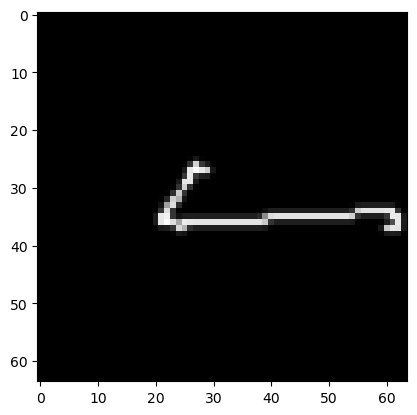

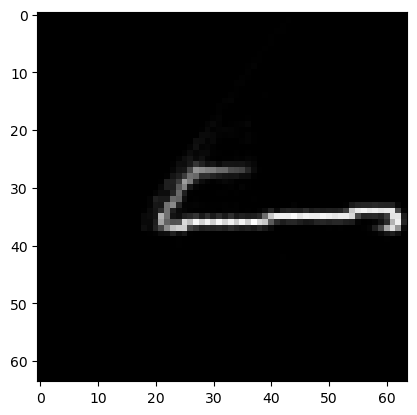

In [1265]:
idx = np.random.randint(0, len(X_images))

plt.imshow(X_images[idx].reshape(64, 64), cmap='gray')
plt.show()

plt.imshow(Y_images[idx].reshape(64, 64), cmap='gray')
plt.show()


In [1266]:
latent_space = model.latent.detach().cpu().numpy()
latent_space.shape

latent_space_noisy = model.noisy_latent.detach().cpu().numpy()

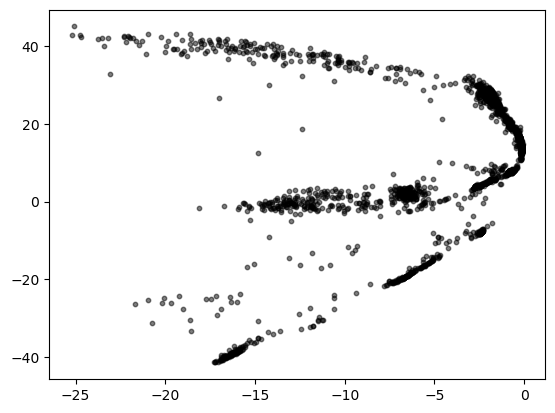

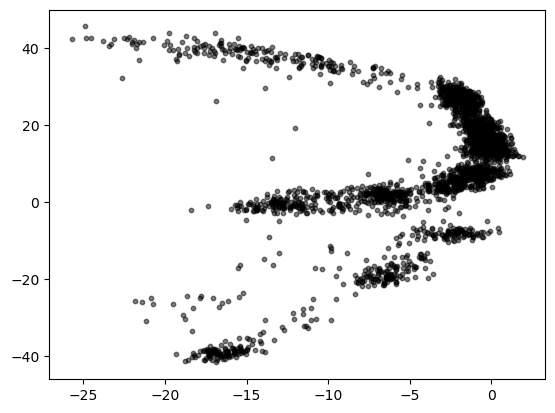

In [1267]:
plt.scatter(latent_space[:,0], latent_space[:,1], marker='o', color='black', alpha=0.5, s=10)
plt.show()
plt.scatter(latent_space_noisy[:,0], latent_space_noisy[:,1], marker='o', color='black', alpha=0.5, s=10)

In [1150]:
colormap = mpl.colormaps["tab20"]


In [1254]:
from sklearn.mixture import GaussianMixture

method = "GaussianMixture"

latent = latent_space
clustering = GaussianMixture(n_components=10).fit(latent)
clusters = clustering.predict(latent)
probs = clustering.predict_proba(latent)
np.unique(clusters, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([362, 151, 207, 153, 458, 163, 323,  76, 349, 375]))

In [718]:
probs

array([[1.68681827e-082, 1.18354302e-075, 1.01986363e-002, ...,
        8.91756667e-012, 0.00000000e+000, 0.00000000e+000],
       [3.70670183e-047, 3.16129643e-034, 1.00000000e+000, ...,
        5.07253504e-042, 0.00000000e+000, 0.00000000e+000],
       [7.54443792e-081, 4.52016533e-074, 8.33887428e-003, ...,
        1.91050006e-011, 0.00000000e+000, 0.00000000e+000],
       ...,
       [9.02036010e-148, 1.20593177e-070, 1.27063999e-003, ...,
        8.69252804e-095, 0.00000000e+000, 0.00000000e+000],
       [1.97928243e-174, 1.57060393e-063, 3.10208387e-004, ...,
        3.20719211e-096, 0.00000000e+000, 0.00000000e+000],
       [4.91955113e-223, 3.26891778e-020, 3.76132186e-005, ...,
        3.95234955e-101, 0.00000000e+000, 0.00000000e+000]])

In [1252]:
from sklearn.cluster import HDBSCAN

method="HDBSCAN"

latent = latent_space
clustering = HDBSCAN(min_cluster_size=100, max_cluster_size=800).fit(latent)
clusters = clustering.labels_ + 1
np.unique(clusters, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([718, 114, 101, 104, 205, 403, 411, 149, 249, 163]))

In [715]:
probs

NameError: name 'probs' is not defined

In [1257]:
from sklearn.cluster import KMeans

method="KMeans"

latent = latent_space
clustering = KMeans(n_clusters=10).fit(latent)
clusters = clustering.predict(latent)
np.unique(clusters, return_counts=True)

/opt/homebrew/Caskroom/miniforge/base/envs/artefact/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([263, 141, 270, 177, 140, 452, 411, 493, 164, 106]))

10

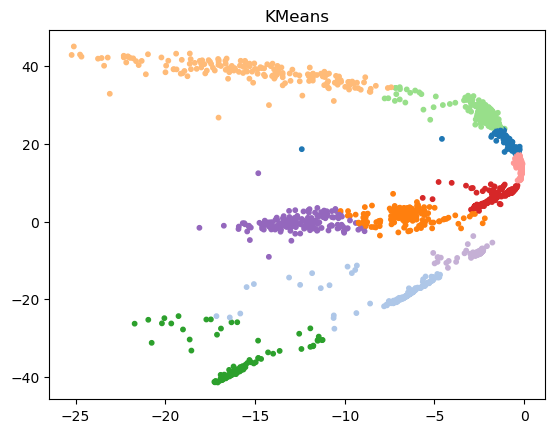

In [1258]:
plt.scatter(latent[:, 0], latent[:, 1], c=[colormap(c) for c in clusters], s=10)
# plt.colorbar()
plt.title(f"{method}")
len(np.unique(clusters))


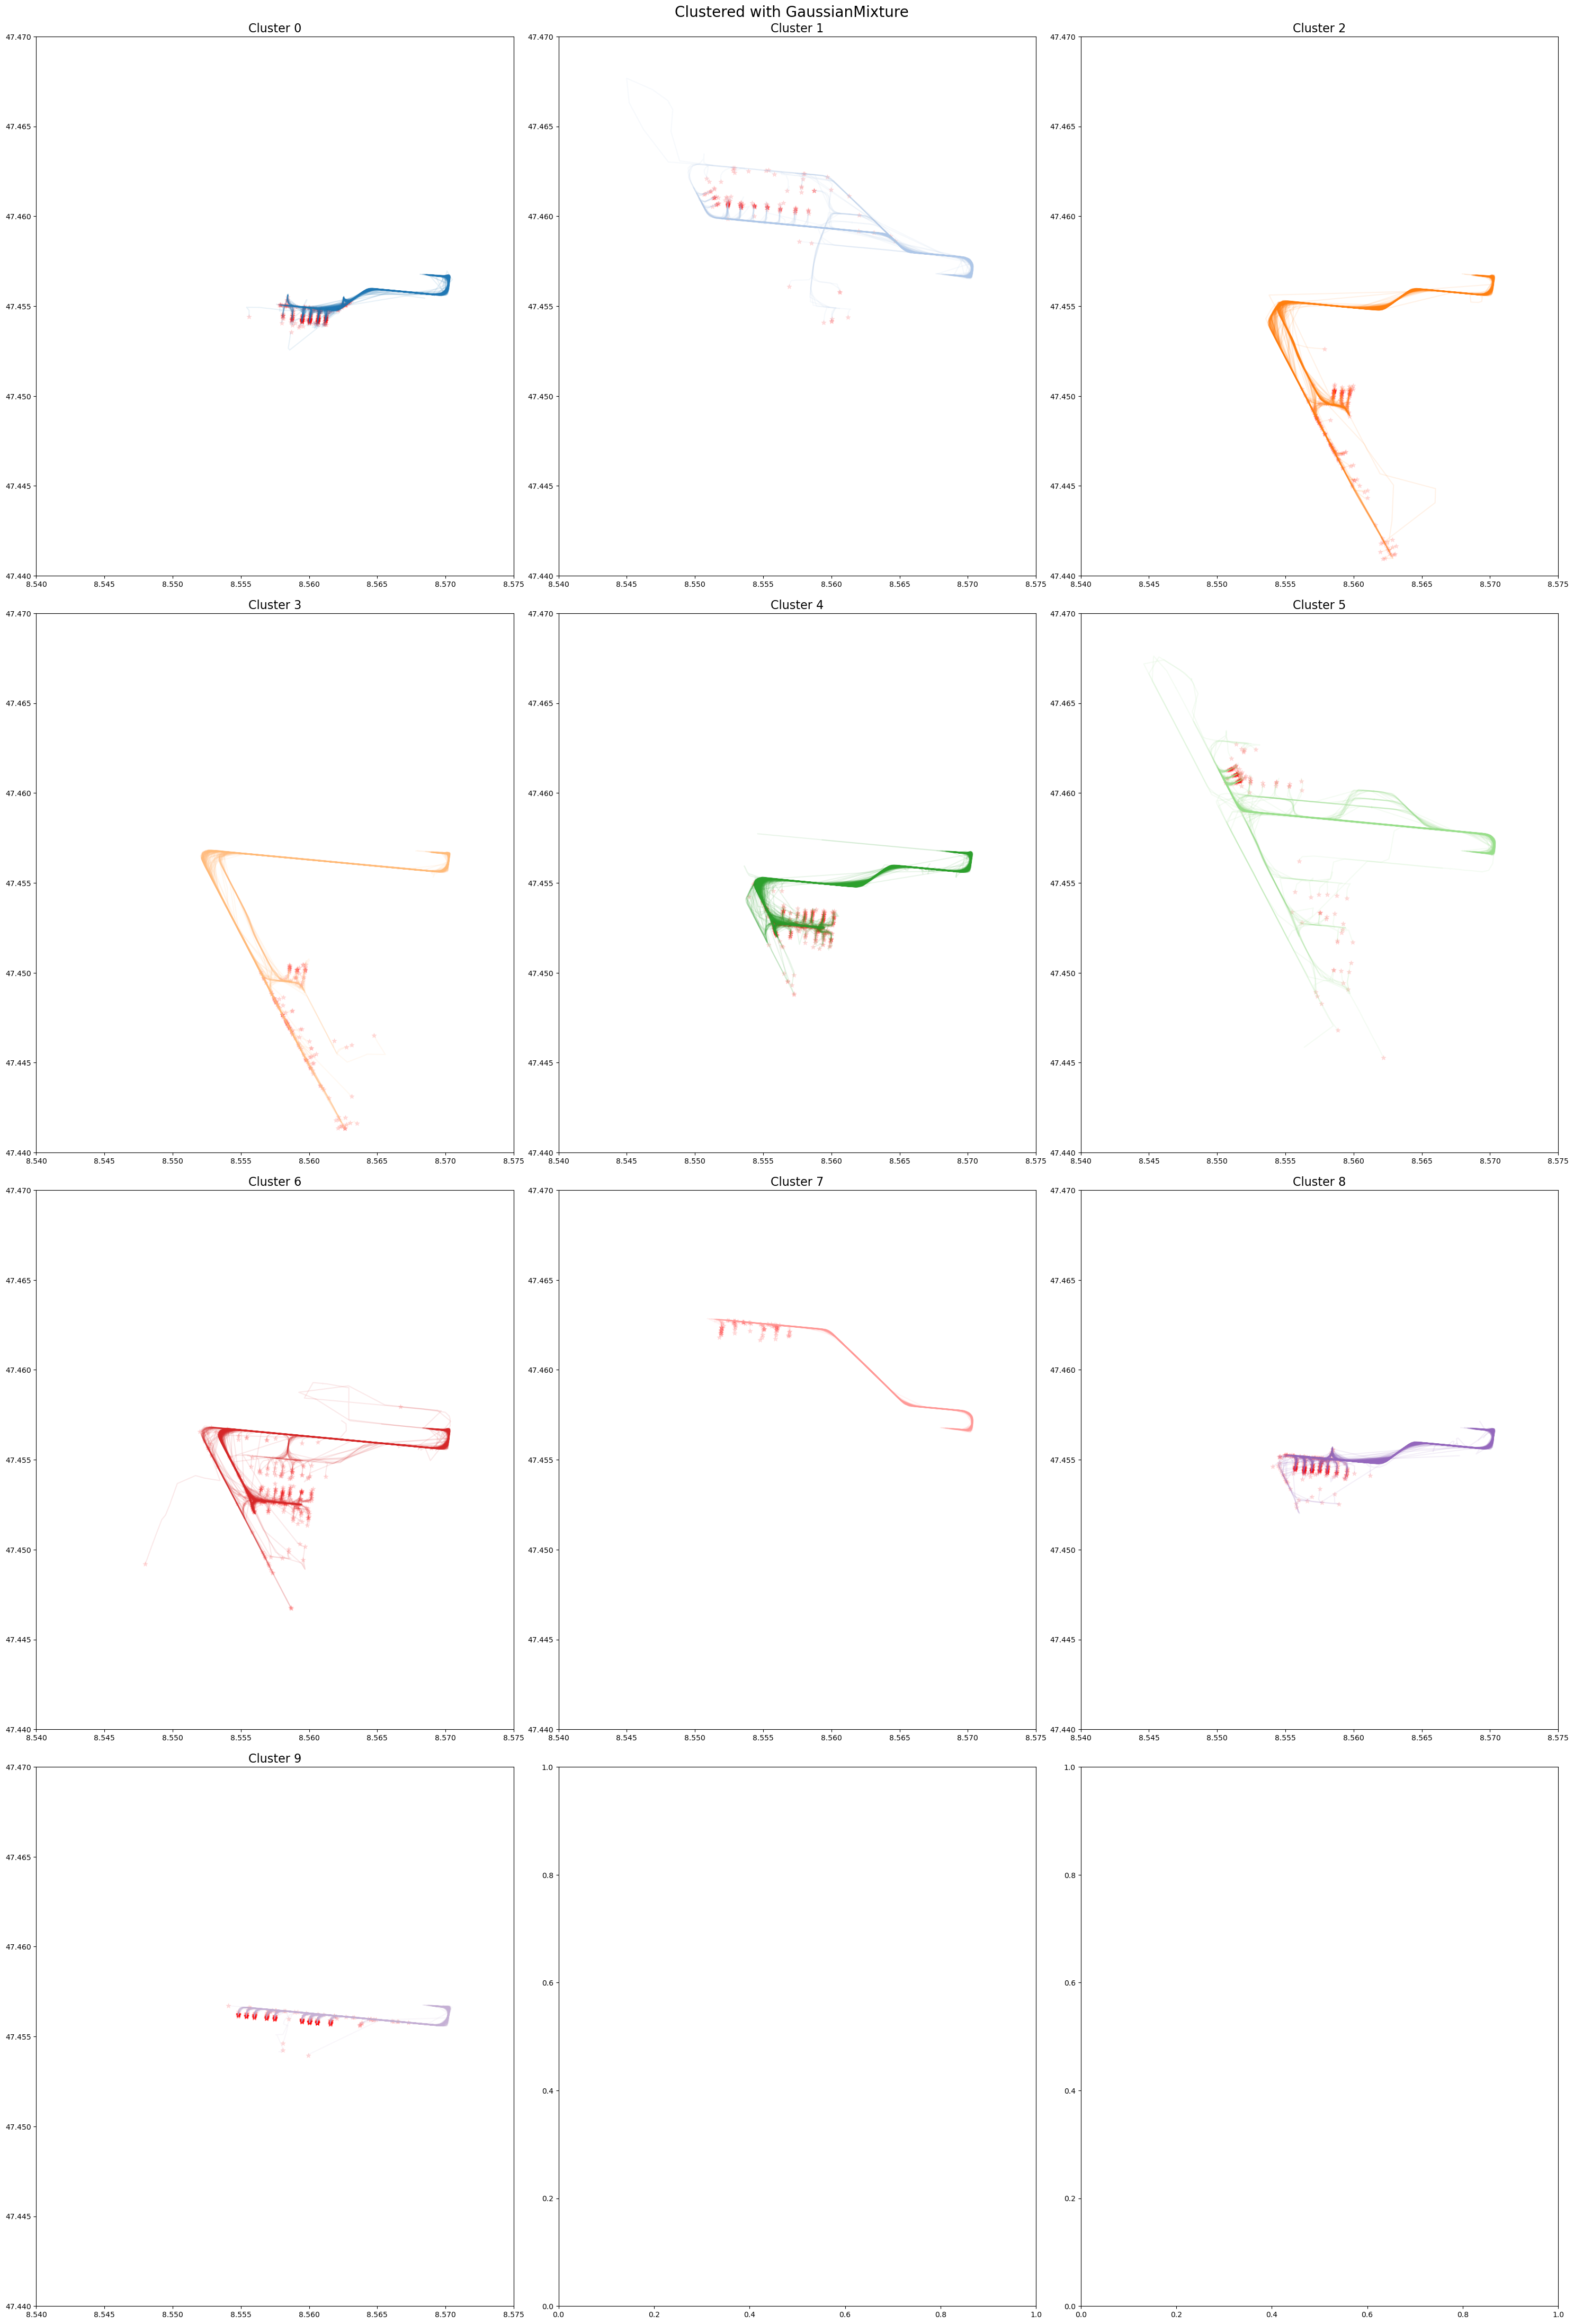

In [1256]:
figsize = (3, 4)


fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(30, 45))
fig.suptitle(f"Clustered with {method}\n", fontsize=20)
fig.tight_layout(pad=3.0)

order = np.array(flight_order)

for cluster in np.unique(clusters):
    cluster_mask = clusters == cluster
    flights = t_f[order[cluster_mask]]

    with plt.style.context("traffic"):
        ax = axs[cluster // 3, cluster % 3]

        for flight in flights:
            flight.plot(ax=ax, alpha=0.1, color=colormap(cluster))
            ax.scatter(
                flight.data.longitude.iloc[0],
                flight.data.latitude.iloc[0],
                s=40,
                color="red",
                marker="*",
                alpha=0.1,
            )

        ax.set_title(f"Cluster {cluster}")
        ax.set_xlim(8.54, 8.575)
        ax.set_ylim(47.44, 47.47)

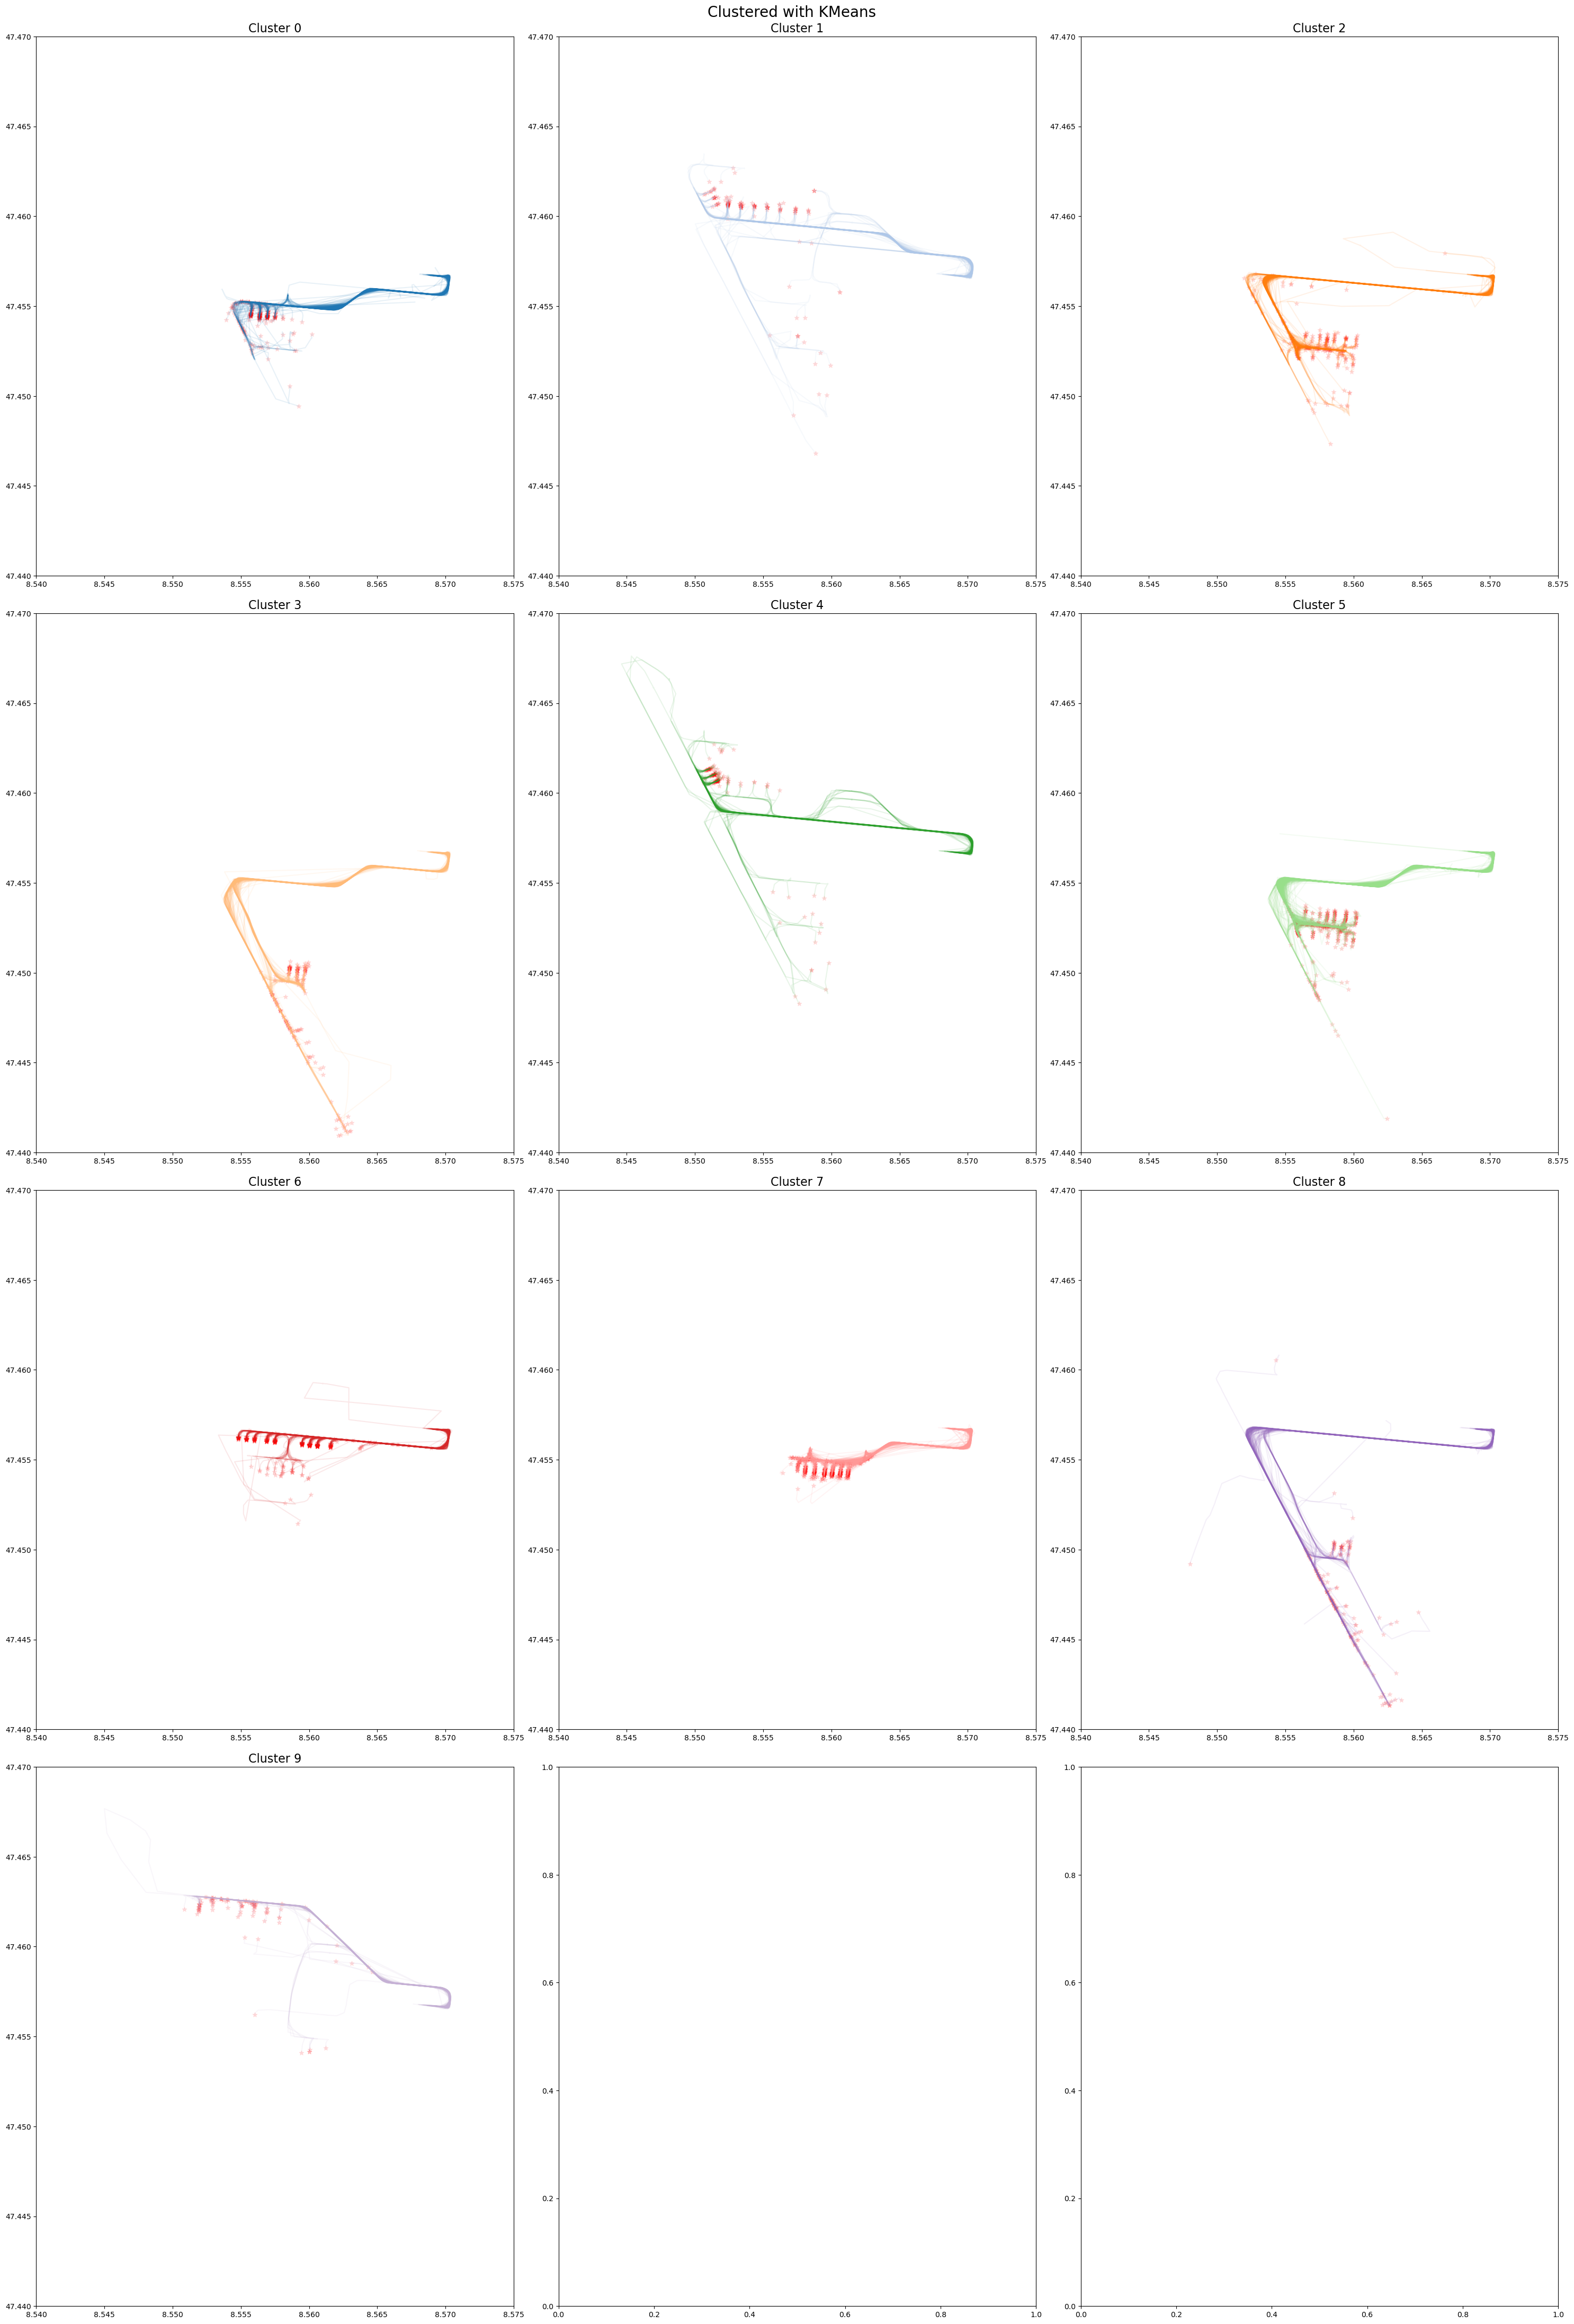

In [1259]:
figsize = (3, 4)


fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(30, 45))
fig.suptitle(f"Clustered with {method}\n", fontsize=20)
fig.tight_layout(pad=3.0)

order = np.array(flight_order)

for cluster in np.unique(clusters):
    cluster_mask = clusters == cluster
    flights = t_f[order[cluster_mask]]

    with plt.style.context("traffic"):
        ax = axs[cluster // 3, cluster % 3]

        for flight in flights:
            flight.plot(ax=ax, alpha=0.1, color=colormap(cluster))
            ax.scatter(
                flight.data.longitude.iloc[0],
                flight.data.latitude.iloc[0],
                s=40,
                color="red",
                marker="*",
                alpha=0.1,
            )

        ax.set_title(f"Cluster {cluster}")
        ax.set_xlim(8.54, 8.575)
        ax.set_ylim(47.44, 47.47)

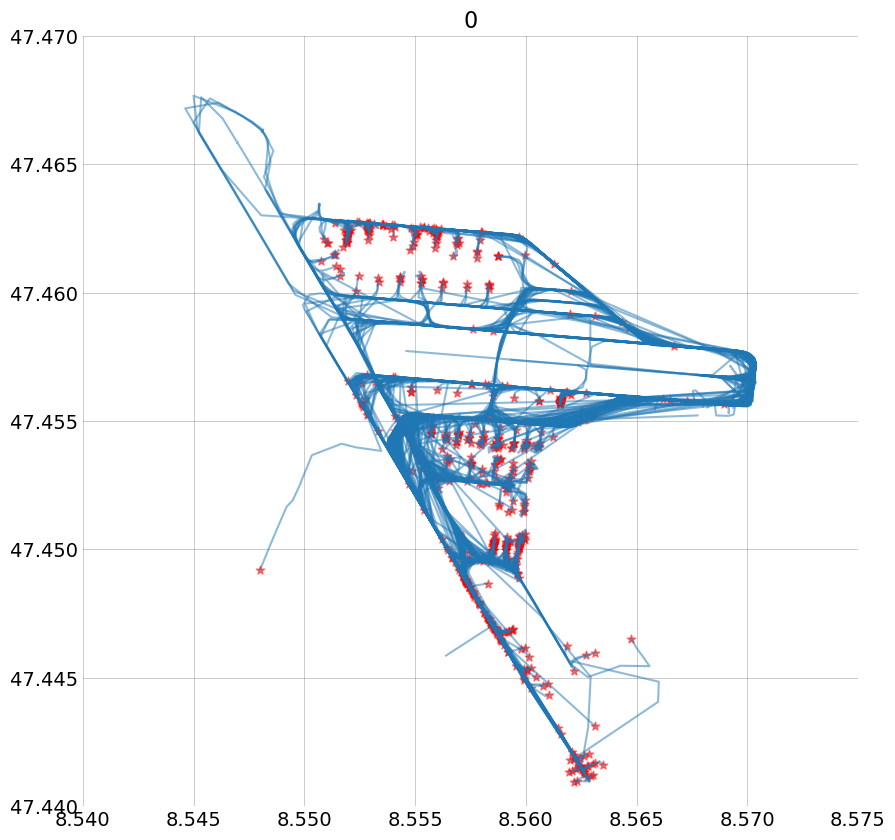

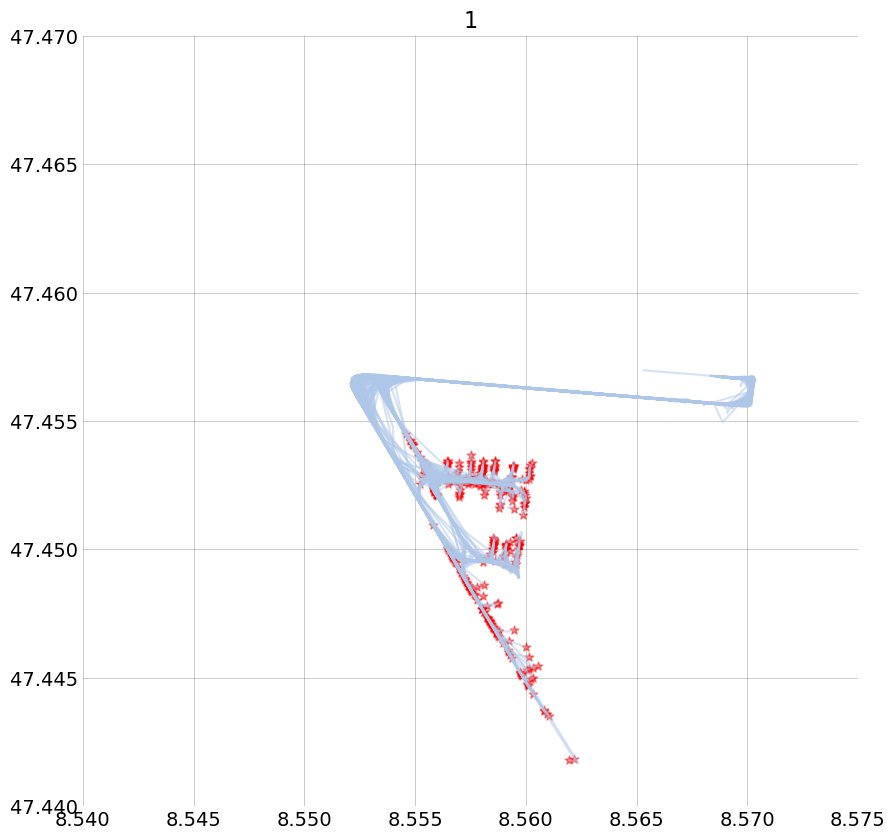

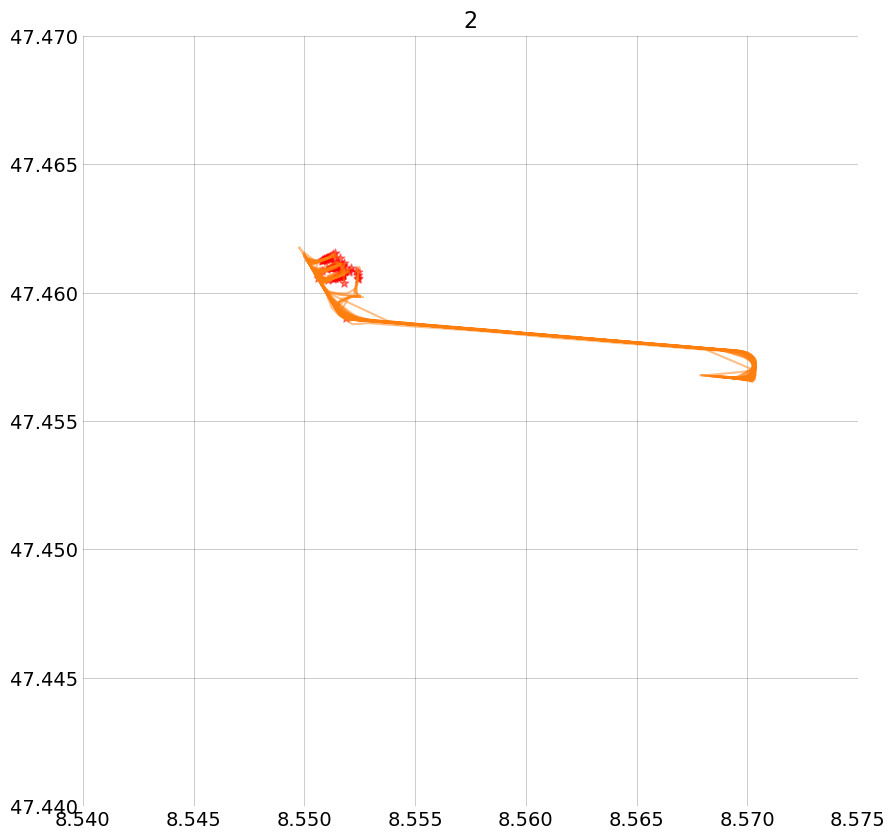

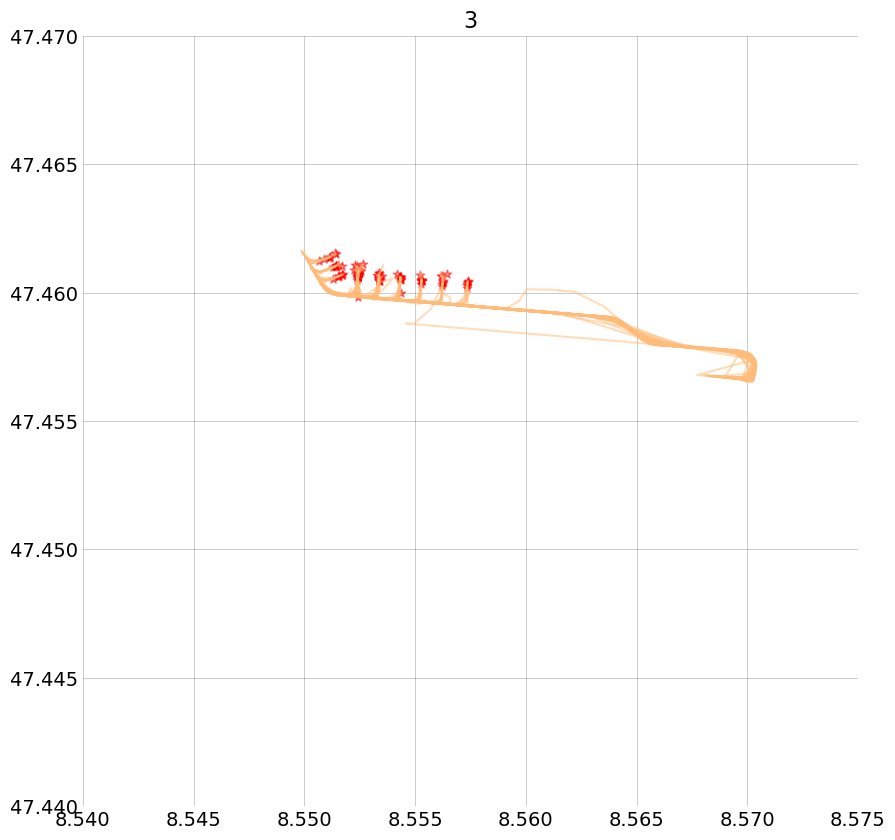

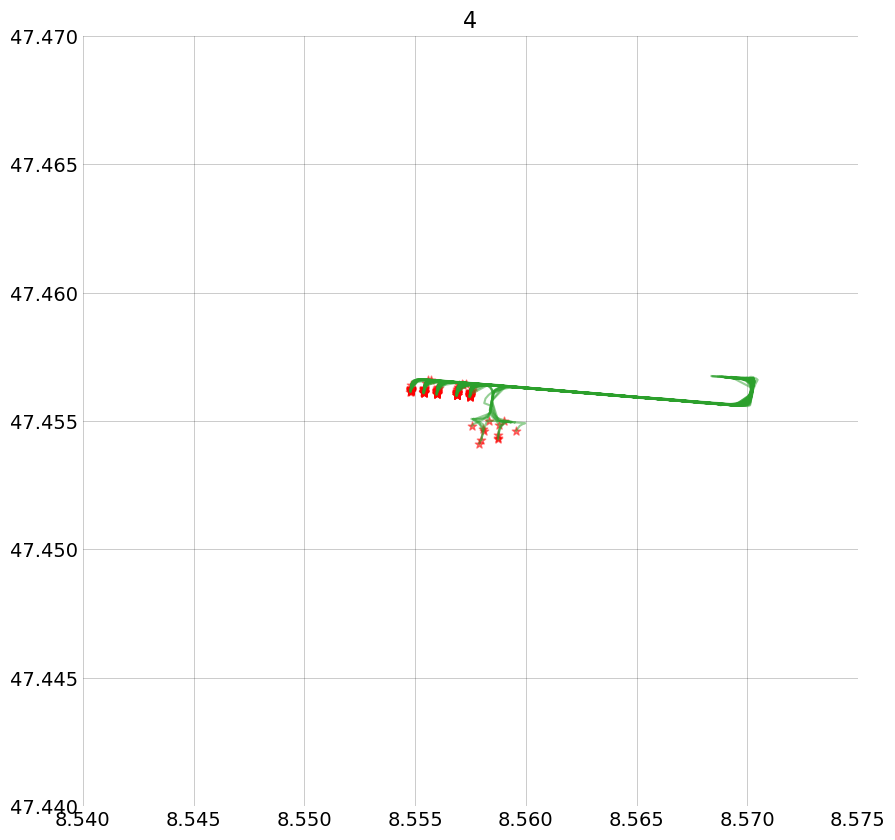

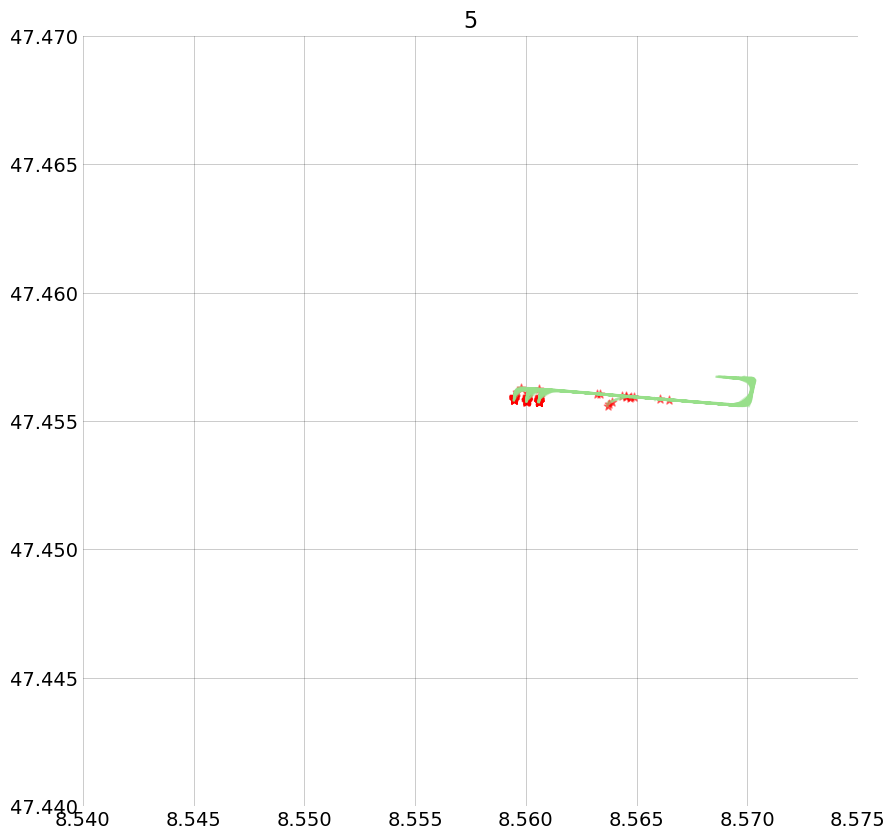

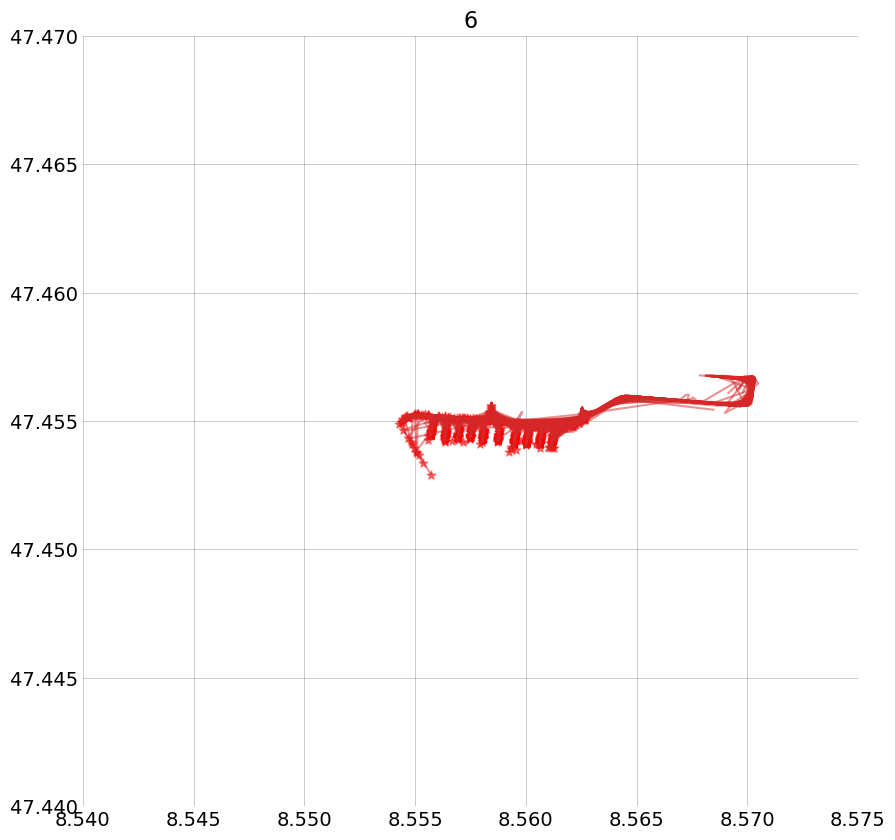

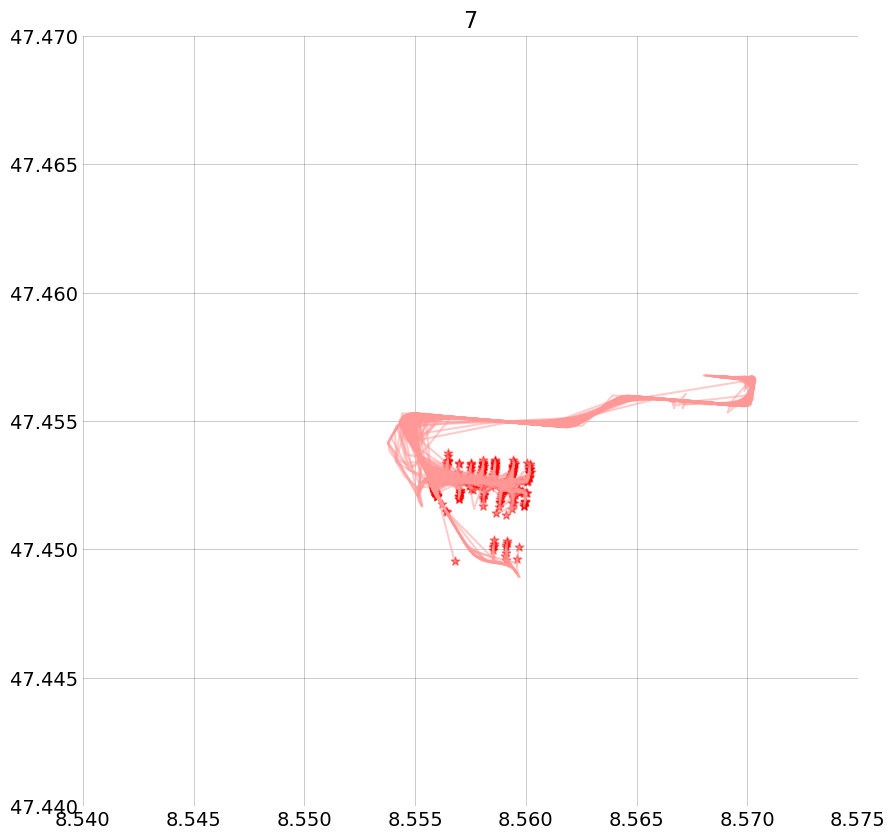

In [675]:
for cluster_ in np.unique(clusters):
    with plt.style.context("traffic"):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title(cluster_)

        for cluster, flight_id in zip(clusters, flight_order):
            if cluster != cluster_:
                continue
            flight = t_f[flight_id]
            ax.scatter(
                flight.data.longitude.iloc[0],
                flight.data.latitude.iloc[0],
                s=40,
                color="red",
                marker="*",
                alpha=0.5,
            )
            flight.plot(ax=ax, alpha=0.5, color=colormap(cluster))
            ax.set_xlim(8.54, 8.575)
            ax.set_ylim(47.44, 47.47)
        
        plt.show()